In [1]:
import numpy as np
import math
import os
import time
import re
import random
import shutil

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

from scipy.ndimage.filters import gaussian_filter
from skimage.morphology import square, disk, dilation

from PIL import Image
import pandas as pd
from scipy import ndimage

from correlation import *
from utils import *

In [2]:
# top directory for processing results
#path_proc = 'proc_18_08_10\\'
path_proc = 'proc\\'

path_raw = path_proc +    'raw\\'
path_input = path_proc +  'input\\'
path_amp = path_proc +    'amp\\'
path_flow_x = path_proc + 'flow_x\\'
path_flow_y = path_proc + 'flow_y\\'
path_corr = path_proc +   'corr\\'
path_width = path_proc +  'width\\'

In [40]:
pixel_size = 4.0 # pixel size in micrometers
bunch_period = 176  # 176 ns bunch separation period
time_factor = bunch_period / 1000.0   # in microseconds
vel_factor = pixel_size / time_factor


sample_rate = 31.25 # sample rate = 32000 fps -> frame separation 31,2 microseconds

bern_vel = 250.0

# Number of shots for intergrated analysis
shots_num = 5
# Sequence length
seq_length = 40


# Filtering paramters
filter_high = True
filter_zero = True
filter_corr = True
            
max_vel_in_pixels = 10
min_corr_value = 0.2

# Radius of the pacth for overall statistics analysis
rx = 40
ry = 20

rx = 20
ry = 10

print('Velocity per pixel = {0:.2f} m/s'.format(vel_factor))
print('Bernoulli limit {0:.2f} m/s = {1:.2f} pixels'.format(bern_vel, bern_vel / vel_factor))
print('')
print('Velocity examples {0:d} pixel = {1:.2f} m/s'.format(6, 6*vel_factor))
print('Velocity examples {0:d} pixel = {1:.2f} m/s'.format(7, 7*vel_factor))
print('Velocity examples {0:d} pixel = {1:.2f} m/s'.format(10, 10*vel_factor))

Velocity per pixel = 22.73 m/s
Bernoulli limit 250.00 m/s = 11.00 pixels

Velocity examples 6 pixel = 136.36 m/s
Velocity examples 7 pixel = 159.09 m/s
Velocity examples 10 pixel = 227.27 m/s


In [41]:
#---------------------------
#   Colors
#---------------------------

blue = (57 / 255.0, 106 / 255.0, 177 / 255.0)
red = (204/ 255.0, 37/ 255.0, 41/ 255.0 )
green = (62/ 255.0, 150/ 255.0, 81/ 255.0 )  
grey = (128/ 255.0, 133/ 255.0, 133/ 255.0 )
gold = (237/ 255.0, 218/ 255.0, 116/ 255.0 )

#---------------------------
#   Fonts
#---------------------------

title_font_size = 20
label_font_size = 16
ticks_font_size = 16

In [42]:
def read_files_save_as_multitiff_stack(path, file_name):
    files = sorted([f for f in listdir(path) if isfile(join(path, f))])
    print('Number of images to convert:', len(files))

    imlist = []
    for f in files:
        #im = np.array(Image.open(p + f))
        #imlist.append(Image.fromarray(m))
        with Image.open(path + f) as im:
            np_im = np.array(im)
            imlist.append(Image.fromarray(np_im))

    imlist[0].save(file_name, save_all=True, append_images=imlist[1:])

    print('OK')
    
    #return np.array(imlist)

In [50]:
#----------------------------#
# Time analysis              #
#----------------------------#
def time_analysis(images, corr_images, cx, cy, rx, ry, y_pos=60, ax=None, region='all', show=False, color='k'):
    
    if  not ax:
        ax  = plt.subplot(111)

    #def avg_nonzero(a): 
    #    return np.mean(a[a > 0])

    all_shots_vel = []

    #for s in range(1):    
    for s in range(shots_num):
        # Get sequence for the shot
        seq = images[s*seq_length:(s+1)*seq_length]
        seq_corr = corr_images[s*seq_length:(s+1)*seq_length]

        mean_vel_values = []

        #for i in range(1):
        for i in range(seq_length): 

            im = seq[i][cy-ry:cy+ry,cx-rx:cx+rx]
            c = seq_corr[i][cy-ry:cy+ry,cx-rx:cx+rx]
            #print(cy-r_2, cx-r_2)

            # Filtering
            
            # 1. Put away large velocity outliers
            #filtered_amp = np.where(im < 10, im, 0)
            if filter_high:
                im = np.where(im < max_vel_in_pixels, im, 0)
                
            # 2. Drop velocities with low correlation values
            if filter_corr:
                filtered_corr = np.where(c > min_corr_value, 1, 0)
                im = im*filtered_corr
                #filtered_corr = 1.0
                
            # 3. Drop zero velocities from avareging
            if filter_zero:
                nonzero_values = im[im > 0]
                if len(nonzero_values) == 0:
                    im = 0.0
                else:
                    im = np.mean(nonzero_values)
            
                
            
            #amp_nonzeros_mean = np.mean(filtered_amp[filtered_amp > 0])
            if not (filter_high and filter_zero):
                im = np.mean(im)
                

            # Convert to m/s
            im = im*vel_factor
            #amp_nonzeros_mean = amp_nonzeros_mean*vel_factor

            mean_vel_values.append(im)
            #mean_vel_values.append(amp_nonzeros_mean)

        all_shots_vel.append(mean_vel_values)
        #ax.plot(mean_vel_values, linewidth=1.0, alpha=0.3)

    all_shots_mean = np.mean(np.array(all_shots_vel), axis=0)
    ax.plot(all_shots_mean, linewidth=2.0, color=color, linestyle='dashed')

    
    ax.set_title('Velocity evolution, region: ' + region, size=title_font_size)
    
    x_lables = ['{:.1f}'.format(x) for x in np.arange(20, (20+seq_length)+1, 5)*sample_rate / 1000]
    x_ticks = np.arange(0, seq_length+1, 5)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_lables, fontsize = ticks_font_size)
    
    ax.set_ylabel('velocity, [m\s]', size=label_font_size)
    ax.set_xlabel('time from injection, [s]', size=label_font_size)


    overall_mean = np.mean(all_shots_mean)
    overall_std = np.std(all_shots_mean)

    #print('Overall average in region {0:.2f} m/s'.format(overall_mean))
    #print('Overall variation in region {0:.2f} m/s'.format(overall_std))
    #print('Variation in percent {0:.1f} %'.format(overall_std / overall_mean * 100))
    
    ax.text(1, y_pos, 'Mean: {0:.2f} m/s'.format(overall_mean), fontsize=14, color=color)
    ax.text(16, y_pos, 'STD: {0:.2f} m/s'.format(overall_std), fontsize=14, color=color)

    ax.set_ylim(50,140)
    ax.yaxis.set_tick_params(labelsize=label_font_size)
    
    if show:
        plt.show()
        
    return overall_mean, overall_std


In [44]:
def avg_nonzero(a): 
    
    non_zero_vals = a[a > 0]
    
    if len(non_zero_vals) == 0:
        return 0.0
    else:
        return np.mean(non_zero_vals)

In [45]:
#----------------------------------------
# Read dataset list  
#----------------------------------------

import pickle

with open ('datasets\\datasets_list_all_18_09_10', 'rb') as fp:
    dataset_list = pickle.load(fp)

print('In total {0:d} datasets'.format(len(dataset_list)))


In total 33 datasets


---------------------------------
All Dataset for 19_08_10         
---------------------------------
          days geometry       view    op temp1 press temp2  region
26   09.3-10.3    002_3  Ansicht 0  1bar  25°C   100  25°C    Z5Y0
27   09.3-10.3    002_3  Ansicht 0  1bar  25°C   100  25°C  Z2.5Y0
28   09.3-10.3    002_3  Ansicht 0  1bar  25°C   100  25°C    Z0Y0
73   10.3-11.3    003_1  Ansicht 0  1bar  25°C   100  25°C    Z0Y0
71   10.3-11.3    003_1  Ansicht 0  1bar  25°C   100  25°C    Z5Y0
72   10.3-11.3    003_1  Ansicht 0  1bar  25°C   100  25°C  Z2.5Y0
82   10.3-11.3    005_1  Ansicht ?  1bar  25°C   100  25°C    Z0Y0
80   10.3-11.3    005_1  Ansicht ?  1bar  25°C   100  25°C    Z5Y0
81   10.3-11.3    005_1  Ansicht ?  1bar  25°C   100  25°C  Z2.5Y0
64   10.3-11.3    007_1  Ansicht ?  1bar  25°C   100  25°C    Z0Y0
63   10.3-11.3    007_1  Ansicht ?  1bar  25°C   100  25°C  Z2.5Y0
62   10.3-11.3    007_1  Ansicht ?  1bar  25°C   100  25°C    Z5Y0
50   09.3-10.3    018_1  Ansicht 0  1bar  25°C   100  25°C    Z5Y0
51   09.3-10.3    018_1  Ansicht 0  1bar  25°C   100  25°C  Z2.5Y0
52   09.3-10.3    018_1  Ansicht 0  1bar  25°C   100  25°C    Z0Y0
100  10.3-11.3    019_1  Ansicht 0  1bar  25°C   100  25°C    Z0Y0
99   10.3-11.3    019_1  Ansicht 0  1bar  25°C   100  25°C  Z2.5Y0
98   10.3-11.3    019_1  Ansicht 0  1bar  25°C   100  25°C    Z5Y0
91   10.3-11.3    020_1  Ansicht 0  1bar  25°C   100  25°C    Z0Y0
90   10.3-11.3    020_1  Ansicht 0  1bar  25°C   100  25°C  Z2.5Y0
89   10.3-11.3    020_1  Ansicht 0  1bar  25°C   100  25°C    Z5Y0
46   09.3-10.3    021_1  Ansicht 0  1bar  25°C   100  25°C    Z0Y0
45   09.3-10.3    021_1  Ansicht 0  1bar  25°C   100  25°C  Z2.5Y0
44   09.3-10.3    021_1  Ansicht 0  1bar  25°C   100  25°C    Z5Y0
32   09.3-10.3    023_1  Ansicht 0  1bar  25°C   100  25°C    Z5Y0
33   09.3-10.3    023_1  Ansicht 0  1bar  25°C   100  25°C  Z2.5Y0
34   09.3-10.3    023_1  Ansicht 0  1bar  25°C   100  25°C    Z0Y0
58   09.3-10.3    025_1  Ansicht 0  1bar  25°C   100  25°C    Z0Y0
107  10.3-11.3    025_1  Ansicht 0  1bar  25°C   100  25°C    Z5Y0
108  10.3-11.3    025_1  Ansicht 0  1bar  25°C   100  25°C  Z2.5Y0
109  10.3-11.3    025_1  Ansicht 0  1bar  25°C   100  25°C    Z0Y0
57   09.3-10.3    025_1  Ansicht 0  1bar  25°C   100  25°C  Z2.5Y0
56   09.3-10.3    025_1  Ansicht 0  1bar  25°C   100  25°C    Z5Y0
In total: 33




--------------------
Date: today
Dataset: sim
Region: 
--------------------

Analysis...
OK


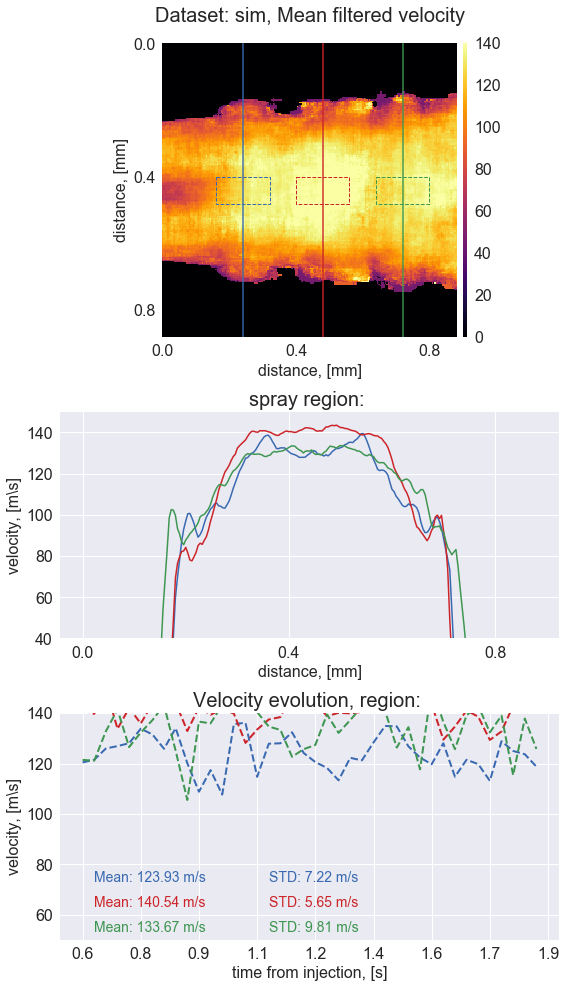

Finished!


In [51]:
#----------------------------------------
# Select dataset for processing
#----------------------------------------

process_all_datasets = True

run_collect_results = False
run_make_figures = True
run_save_results_table = False
run_move_files = False

if process_all_datasets:
    results_table = []
    df = pd.DataFrame(columns=['Date', 'Dataset', 'Region', 'AvgVelA', 'StdVelA', 'AvgVelB', 'StdVelB', 'AvgVelC', 'StdVelC'])

    #for dt in dataset_list[0:2]:
    #for dt in dataset_list:
    for xx in range(1):

        #date = dt[0]
        #dataset = dt[1]
        #region = dt[2]
        #path = dt[3]
        #path = path.replace('\\', '/') # Uncomment for running on Linux
        #path = path.replace('y:', '/mnt/LSDF') # Uncomment for running on Linux
        #path+='\\'
        #file_name = dt[4]
        
        # Simulation
        path  = 'y:\\projects\\pn-reduction\\ershov\\'
        dataset = 'sim'
        date = 'today'
        region = ''


        print('\n--------------------')
        print('Date:', date)
        print('Dataset:', dataset)
        print('Region:', region)
        print('--------------------\n')

        if date == '09.3-10.3':
            d = '09-10' 

        if date == '10.3-11.3':
            d = '10-11'        

        if date == '11.3-11.3':
            d = '11-12' 

        #results_path = path + path_proc + d + '_' + dataset + '_' + region
        results_path = path + path_proc
        d = '' 
        
        #------------------------------
        # Collect results
        #------------------------------
        if run_collect_results:
            read_files_save_as_multitiff_stack(path + path_amp, results_path + '_amp_seq.tif')
            read_files_save_as_multitiff_stack(path + path_corr, results_path + '_corr_seq.tif')


        if run_make_figures:
            
            # Read dataset
            max_read_images = 200  

            #start = time()
            images = read_tiff(results_path +'_amp_seq.tif', max_read_images)
            corr   = read_tiff(results_path +'_corr_seq.tif', max_read_images)

            #end = time()
            #print ('Time elapsed: ', (end-start))

            #------------------------------
            # Start analysis
            #------------------------------

            print('Analysis...')

            # Make masking
            med = np.median(images, axis=0)  
            thres = np.where(med > 5, 255.0, 0.0)
            dilated = dilation(thres, disk(6))
            mask = gaussian_filter(dilated, 3.5) 
            im_res = Image.fromarray(mask)
            im_res.save(results_path + '_mask.tif')

            # Mean velocity without any filtering
            amp_mean = np.mean(images, axis=0)
            im_res = Image.fromarray(amp_mean*vel_factor)
            im_res.save(results_path + '_amp_mean_nofilter.tif')

            # Filtering according to physical contraints

            filtered_amp = np.where(images < max_vel_in_pixels, images, 0)
            #filtered_amp = images # no filtering
            #filtered_amp = np.where(np.abs(images) < 10, images, 0) # Filter y-components
            filtered_corr = np.where(corr > min_corr_value, 1, 0)
            #filtered_corr = 1.0
            filtered_amp = filtered_amp*filtered_corr

            amp_filtered_mean = np.apply_along_axis(avg_nonzero, 0, filtered_amp)
            im_res = Image.fromarray(amp_filtered_mean*vel_factor)
            im_res.save(results_path + '_amp_mean_filter.tif')

            measure_name = 'Mean filtered velocity'
            measure_file = 'amp_mean_filter'

            pano = amp_filtered_mean*vel_factor

            amp_seq = images


            # Setup figure
            fig = plt.figure(1)

            fig.set_size_inches(20/3 + 2, 14, forward=True)
            plt.subplots_adjust(top=0.95, bottom=0.06, left=0.1, right=0.90, hspace=0.3 )

            gs = gridspec.GridSpec(3, 1, height_ratios=[1.3,1,1])

            #-------------------------------------------
            # Figure 1: Velocity maps
            #-------------------------------------------

            # Setup figure
            ax0 = plt.subplot(gs[0,:])

            imx = ax0.imshow(pano, vmax=140, cmap='inferno')
            ax0.set_title('Dataset: '+ dataset +', '+ measure_name, size=title_font_size, y=1.05)    
            ax0.set_xlabel('distance, [mm]', size=label_font_size)
            ax0.set_ylabel('distance, [mm]', size=label_font_size)

            width = pano.shape[1]
            x_lables = ['{:.1f}'.format(x) for x in np.arange(0, width+1, 100) /1000*pixel_size]
            x_ticks = np.arange(0, width+1, 100)
            ax0.set_xticks(x_ticks)
            ax0.set_xticklabels(x_lables, fontsize = ticks_font_size)

            height = pano.shape[0]
            y_lables = ['{:.1f}'.format(x) for x in np.arange(0, height+1, 100) /1000*pixel_size]
            y_ticks = np.arange(0, height+1, 100)
            ax0.set_yticks(y_ticks)
            ax0.set_yticklabels(y_lables)

            ax0.yaxis.set_tick_params(labelsize=label_font_size)

            axins0 = inset_axes(ax0,
                               width="1.5%",  # width = 10% of parent_bbox width
                               height="100%",  # height : 50%
                               loc=3,
                               bbox_to_anchor=(1.02, 0., 1, 1),
                               bbox_transform=ax0.transAxes,
                               borderpad=0                    
                               )

            # Separation lines between combined images

            clb = plt.colorbar(imx, cax=axins0)
            clb.ax.tick_params(labelsize=ticks_font_size)

            #step = int(350 / 2)
            step = int(120 / 2)

            ax0.axvline(step*1,linewidth=2, color=blue, alpha=0.7)
            ax0.axvline(step*2,linewidth=2, color=red, alpha=0.7)
            ax0.axvline(step*3,linewidth=2, color=green, alpha=0.7)


            # Create a Rectangle patch
            rect1 = patches.Rectangle((step*1 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=blue,facecolor='none', alpha=1.0)
            ax0.add_patch(rect1)

            rect2 = patches.Rectangle((step*2 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=red,facecolor='none', alpha=1.0)
            ax0.add_patch(rect2)

            rect3 = patches.Rectangle((step*3 - rx, height/2-ry),2*rx,2*ry,linewidth=1, linestyle='--',edgecolor=green,facecolor='none', alpha=1.0)
            ax0.add_patch(rect3)

            ax0.grid(False)

            #plt.show()
            #fig.savefig(path + dataset + '_comb_' + measure[1] + '_map.png')


            #-------------------------------------------
            # Figure 2: Velocity profiles
            #-------------------------------------------

            plt.style.use('seaborn')

            #fig.set_size_inches(25, 8, forward=True)
            #plt.subplots_adjust(left=0.05, right=0.95, wspace=0.1)

            data = pano

            smooth_mask = 4

            vel_min = 40
            vel_max = 150


            # Subplot 2
            vel_profile_A = data[:,step*1]
            vel_profile_B = data[:,step*2]
            vel_profile_C = data[:,step*3]

            np.savetxt(results_path + '_vel_profile_A.txt', vel_profile_A, fmt='%.5f')
            np.savetxt(results_path + '_vel_profile_B.txt', vel_profile_B, fmt='%.5f')
            np.savetxt(results_path + '_vel_profile_C.txt', vel_profile_C, fmt='%.5f')

            ax1 = plt.subplot(gs[1,0])
            ax1.set_title('spray region: '+region, size=title_font_size)
            ax1.plot(smooth(vel_profile_A, smooth_mask, 'flat'), linewidth=1.5, color=blue)
            ax1.plot(smooth(vel_profile_B, smooth_mask, 'flat'), linewidth=1.5, color=red)
            ax1.plot(smooth(vel_profile_C, smooth_mask, 'flat'), linewidth=1.5, color=green)
            ax1.set_ylim(vel_min, vel_max)
            ax1.set_ylabel('velocity, [m\s]', size=label_font_size)
            ax1.set_xlabel('distance, [mm]', size=label_font_size)
            ax1.set_xticks(y_ticks)
            ax1.set_xticklabels(y_lables, fontsize = ticks_font_size)
            ax1.yaxis.set_tick_params(labelsize=label_font_size)


            #-------------------------------------------
            # Figure 3: Velocity time evolution
            #-------------------------------------------

            # Subplot 2
            ax4 = plt.subplot(gs[2,0])
            avg_vel_A, std_vel_A = time_analysis(amp_seq, corr, int(width/4), int(height/2), rx, ry, 73, ax4, region=region, show=False, color=blue)
            avg_vel_B, std_vel_B = time_analysis(amp_seq, corr, int(width/2), int(height/2), rx, ry, 63, ax4, region=region, show=False, color=red)
            avg_vel_C, std_vel_C = time_analysis(amp_seq, corr, int(3*width/4), int(height/2), rx, ry, 53, ax4, region=region, show=False, color=green)

    
            all_results_path = 'y:\\projects\\pn-reduction\\2018_03_esrf_mi1325\\Phantom\\Glasduese\\analysis_all_results\\'

            #plt.show()
            fig.savefig(results_path + '_comb_'+ measure_file +'_fig.png')
            fig.savefig(all_results_path + region + '\\' + d + '_' + dataset + '_' + region + '_comb_'+ measure_file +'_fig.png')


            #-------------------------------------------
            # Summary results table
            #-------------------------------------------

            res = [date, dataset, region, avg_vel_A, std_vel_A, avg_vel_B, std_vel_B, avg_vel_C, std_vel_C]

            df.loc[len(df)] = res

            print('OK')
            #results_table.append(res)

            plt.draw()
            plt.show()
            
            
        if run_move_files:
            
            p = path + path_proc
            
            files = [f for f in listdir(p) if (f.find('txt')>-1 or f.find('amp_mean')>-1 or f.find('vel_profile')>-1 )]

            print('Copying files...')
            for f in files:
                shutil.copy(p+f, all_results_path)

            print('OK')
            

    if run_save_results_table:
        df.to_excel(all_results_path + 'results_table.xlsx', sheet_name='Results')

    #file = open(all_results_path + 'results_table.txt', 'w')
    #file.writelines(["%s\n" % item  for item in results_table])
    #file.close()

    #np.savetxt(all_results_path + 'results_table.txt', results_table, fmt='%.2f')

    print('Finished!')    

In [32]:
all_results_path = 'y:\\projects\\pn-reduction\\2018_03_esrf_mi1325\\Phantom\\Glasduese\\analysis_all_results\\'


p = 'y:\\projects\\pn-reduction\\2018_03_esrf_mi1325\\Phantom\\Glasduese\\Nachtschicht 10.3 auf 11.3\\020_1\\Ansicht 0°\\OP_1bar_25°C_100bar_25°C\\Z5Y0\\proc_18_08_10\\'
#p = path + path_proc

#print([f for f in listdir(p) if isfile(join(p, f))])

files = [f for f in listdir(p) if (f.find('txt')>-1 or f.find('amp_mean')>-1 or f.find('vel_profile')>-1 )]

print(files)
print(len(files))

import shutil

print('Copying files...')
for f in files:
    shutil.copy(p+f, all_results_path)
    
print('OK')

['10-11_020_1_Z5Y0_comb_amp_mean_filter_fig.png', '10-11_020_1_Z5Y0_amp_mean_nofilter.tif', '10-11_020_1_Z5Y0_vel_profile_C.txt', '10-11_020_1_Z5Y0_vel_profile_B.txt', '10-11_020_1_Z5Y0_amp_mean_filter.tif', '10-11_020_1_Z5Y0_vel_profile_A.txt']
6
Copying files...
OK
